In [29]:
passYear = 2020
centerNames  = ['Mechanical']
baseDir = "C:/tmp/"
dbName = 'lpu_myperfectice'

In [30]:
# MongoDB Starter
from pymongo import MongoClient
from bson import ObjectId
client = MongoClient('mongodb://localhost:27017/')
db = client[dbName]

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('poster')
sns.set_palette('BuPu_r')
plt.rcParams['figure.figsize'] = [16, 6]

In [32]:
from datetime import datetime
import random as random
import string as string
from slugify import slugify
joiner = '-'

In [33]:
import pandas as pd
import numpy as np
import pickle, json, math

In [34]:
#Change this section as per test name
section = 'Cognitive'  #Core, Programming, Cognitive

In [35]:
#save data to Excel (to be attached as an annexture)
file = slugify(joiner.join(centerNames)) + "_" + section + '_' + ''.join(random.choices(string.ascii_uppercase + string.digits, k=6)) + ".xlsx"
writer = pd.ExcelWriter(baseDir + file, engine='xlsxwriter')

In [36]:
    testNames = ['Cognitive Skill (Quant-Verbal-Reasoning) - 3rd/4th Year - Baseline Test']
#testNames = ['Programming Language (Psuedocode) - Baseline Test']
#testNames = ['CSE/IT (Set2) - 3rd Year Baseline Test 1', 'CSE/IT (Set1) - 3rd Year Baseline Test 1']

In [37]:
#ECE
#testNames = ['Cognitive Skill (Quant-Verbal-Reasoning) - Baseline 1']
#testNames = ['Programming Language Baseline Test 1']
#testNames = ['ECE - 3rd Year - Baseline Test']

In [38]:
#all students who are from a location and passingYear
centers = []
if len(centerNames) > 0:
    centers = pd.DataFrame(list(db.locations.find({'name': {'$in':centerNames} }, {'name': 1})))
    centers = list(centers['_id'])

In [39]:
#Find test details
tests = pd.DataFrame(list(db.practicesets.find({'title': {'$in': testNames}}, {'title':1,'totalQuestion':1, 'totalTime':1})))

In [40]:
tests

,_id,title,totalQuestion,totalTime
0,5c541d04373e87dd388c9af3,Cognitive Skill (Quant-Verbal-Reasoning) - 3rd...,30,2700


In [41]:
#Generate summary of the test
summary = {
    'TestNames': [],
    'Duration': 0,
    'Mode': 'Proctored',
    'Speed': 0,
    'Accuracy': 0,
    'StudentCount': 0,
    'QuestionCount': 0,
    'Complexity': {}
}

In [42]:
summary['TestNames'] = list(tests['title'])
summary['QuestionCount'] = tests['totalQuestion'].mean()
summary['Duration'] = math.floor(tests['totalTime'].mean()/60)

In [43]:
#list(tests['_id'])

In [44]:
#question's complexity analysis
question_query = [
    {
        '$match':{
            '_id': {'$in': list(tests['_id'])}
        }
    },
    {
        '$project':{
        	'questions':1,
        	'title':1
        }
    },
    {
        '$unwind': '$questions'
    },
    {
		'$group': { 
		    '_id': {'title': '$title', 'complexity':'$questions.complexity'}, 
		    'count': { '$sum': 1 }
		} 
    },
    {
        '$project':{
        	'name': '$_id.title',
        	'complexity': '$_id.complexity',
        	'count' : '$count'
        }
    },
    {
        '$group':{
        	'_id': '$complexity',
        	'AvgCount': {'$avg': '$count'}
        }
    },
    {
        '$sort':{
            '_id':1
        }
    }
]
questions = list(db.practicesets.aggregate(question_query))

In [45]:
summary['Complexity'] = questions

In [46]:
if len(centers) > 0:
    studentQuery = {"role": "student", 'lastLogin': {'$ne': ''}, "passingYear": passYear, 'locations': {'$in': centers}}
else:
    studentQuery = {"role": "student", 'lastLogin': {'$ne': ''}, "passingYear": passYear}

In [47]:
studentQuery

{'role': 'student',
 'lastLogin': {'$ne': ''},
 'passingYear': 2020,
 'locations': {'$in': [ObjectId('5bc97b9b6dcc691c7447ea52')]}}

In [48]:
students = pd.DataFrame(list(db.users.find(studentQuery,{"name":1, "phoneNumber":1, 'rollNumber': 1})))

In [49]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 4 columns):
_id            342 non-null object
name           342 non-null object
phoneNumber    192 non-null object
rollNumber     342 non-null int64
dtypes: int64(1), object(3)
memory usage: 10.8+ KB


In [50]:
mentee_pipeline = [
    {
        "$match" : {
            "name": "My Mentees"
        }
    },
    {
        "$unwind" : "$students"
    },
    {
        "$project" : {
            "mentor_id" : "$user",
            "student_id" : "$students.studentId"
        }
    },
    {
        '$lookup':{
            'from': "users",
            'localField': "mentor_id",
            'foreignField': "_id",
            'as': "userInfo"            
        }
    },
    {
        '$project':{
            'mentorName': {'$arrayElemAt': ['$userInfo.name', 0]},
            'studentId': '$student_id'
        }
    }
]

In [51]:
#mentors = pd.DataFrame(list(db.classrooms.aggregate(mentee_pipeline)))

In [52]:
#students = students.merge(mentors, how="left", left_on="_id", right_on="studentId", left_index=False, right_index=False)

In [53]:
#students = students[['name', 'phoneNumber', 'mentorName', 'studentId', 'rollNumber']]

In [54]:
#tests = pd.DataFrame(list(db.practicesets.aggregate({'title': '$in': testNames}, {'_id':1, 'title': 1})))

In [55]:
subject_query = [
	{
	    '$match':{
	    	'isAbandoned': False,
            'practicesetId': {'$in':list(tests['_id'])},
            'user': {'$in': list(students['_id'])}
	    }
	},
    { 
        "$sort" : {
            "createdAt" : 1.0
        }
    },
	{
	    '$group':{
	    	"_id": { "user":"$user", "test_id"  :"$practicesetId"},
	    	'subjects': {'$first': '$subjects'}
	    }
	},
	{
		'$project':{
			'user': '$_id.user',
	        'subjects': 1
	    }
	},
	{
		'$unwind': '$subjects'
	},
	{
		'$project': {
	    	'user': 1,
	        'name': '$subjects.name',
	      	'offscreenTime': {'$floor': {'$divide': [ '$subjects.offscreenTime', 60000]}},
	        'accr': {'$floor': {'$multiply': ['$subjects.accuracy', 100]}} ,
            #'speed': {'$divide': ['$subjects.speed', 1000]},
	       	'totalTime':{'$floor': {'$divide': [{'$multiply': ['$subjects.speed', {'$sum': ['$subjects.incorrect', '$subjects.missed', '$subjects.correct']}]}, 60000]}}
	    }
	},
	{
	    '$group':{
	    	'_id': {'subject':'$name'},
	    	'time': {'$sum': '$totalTime'},
	    	'offscreen': {'$sum': '$offscreenTime'},
	    	'accuracy': {'$avg': '$accr'},
            'speed': {'$avg': '$speed'}
	    }
	},
	{
	    '$project':{
	    	'subject': '$_id.subject',
	    	'time': 1,
	    	'offscreen': 1,
	    	'accuracy': {'$floor': '$accuracy'},
            'speed':{'$floor': '$speed'},
	        '_id': 0,
	    }
	},
    {
        '$sort':{
            'accuracy': 1
        }
    }
]

In [56]:
subjectPerf = pd.DataFrame(list(db.attempts.aggregate(subject_query)))

In [57]:
subjectPerf.head()
subjectPerf.to_excel(writer, sheet_name='subject_summary', index=False)

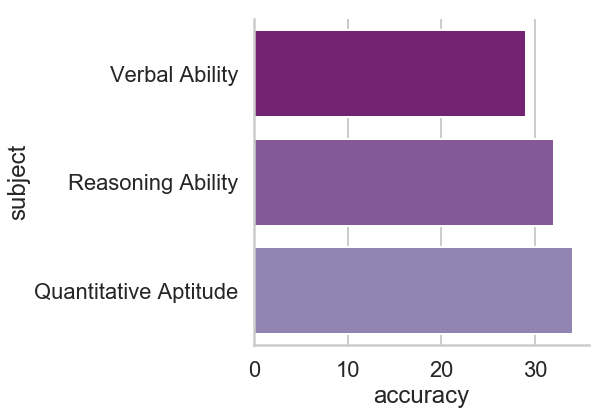

In [58]:
plt.rcParams['figure.figsize'] = [6, 6]
ax = sns.barplot(x='accuracy', y='subject', data=subjectPerf)
#ct.plot.bar(stacked=True)
sns.despine()
file = slugify(joiner.join(centerNames)) + "_subjectPerf_" + ''.join(random.choices(string.ascii_uppercase + string.digits, k=6)) + ".png"
#ax.get_figure().savefig(baseDir + file)
#plt.legend(title='Subject Level Accuracy Summary')

In [59]:
#Student performance/accuracy by subject
student_query = [
	{
	    '$match':{
	    	'isAbandoned': False,
            'practicesetId': {'$in':list(tests['_id'])},
            'user': {'$in': list(students['_id'])}
	    }
	},
    { 
        "$sort" : {
            "createdAt" : 1.0
        }
    },
	{
	    '$group':{
	    	"_id": { "user":"$user", "test_id"  :"$practicesetId"},
	    	'subjects': {'$first': '$subjects'}
	    }
	},
    {
        '$lookup':{
             'from': "users",
             'localField': "_id.user",
             'foreignField': "_id",
             'as': "attempt_users"            
        }
    },
	{
		'$project':{
			'user': '$attempt_users.name',
	        'subjects': 1
	    }
	},
	{
		'$unwind': '$subjects'
	},
	{
		'$project': {
	    	'user': {'$arrayElemAt': ['$user', 0]},
	        'name': '$subjects.name',
            'speed': {'$divide': ['$subjects.speed', 1000]},
	      	#'offscreenTime': {'$floor': {'$divide': [ '$subjects.offscreenTime', 60000]}},
	        'accr': {'$floor': {'$multiply': ['$subjects.accuracy', 100]}}
	       	#'totalTime':{'$floor': {'$divide': [{'$multiply': ['$subjects.speed', {'$sum': ['$subjects.incorrect', '$subjects.missed', '$subjects.correct']}]}, 60000]}}
	    }
	},
	{
	    '$group':{
	    	'_id': {'user': '$user', 'subject':'$name'},
	    	'time': {'$sum': '$totalTime'},
	    	'offscreen': {'$sum': '$offscreenTime'},
	    	'accuracy': {'$avg': '$accr'},
            'speed': {'$avg': '$speed'}
	    }
	},
	{
	    '$project':{
	        '_id': 0,
            'user': '$_id.user',
	    	'subject': '$_id.subject',
	    	#'time': 1,
	    	#'offscreen': 1,
            'speed':{'$floor': '$speed'},
	    	'accuracy': {'$floor': '$accuracy'}  
	    }
	},
    {
        '$sort':{
            'subject': 1,
            'accuracy': 1
        }
    }
]

In [60]:
studentPerf = pd.DataFrame(list(db.attempts.aggregate(student_query)))

In [61]:
studentPerf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 4 columns):
accuracy    333 non-null float64
speed       333 non-null float64
subject     333 non-null object
user        333 non-null object
dtypes: float64(2), object(2)
memory usage: 10.5+ KB


In [62]:
#TBD - It has to be the average of two tests??
summary['StudentCount'] = studentPerf['user'].nunique()
summary['Accuracy'] = math.floor(studentPerf['accuracy'].mean())
summary['Speed'] = math.floor(studentPerf['speed'].mean())

In [63]:
def defineLevel(x):
    if x <= 30:
        return '1. (<=30%)'
    elif x <= 50:
        return '2. (> 30% & <= 50%)'
    elif x <= 70:
        return '3. (> 50% & <=70%)'
    elif x <= 90:
        return '4. (> 70% & <=90%)'
    else:
        return '5. (> 90%)'

In [64]:
studentPerf['PerformanceLevel'] = studentPerf['accuracy'].apply(defineLevel)

In [65]:
slg = pd.crosstab(studentPerf['subject'], studentPerf['PerformanceLevel'], margins=False)

In [66]:
slg.to_excel(writer, sheet_name='studentPerfSummary', index=False)

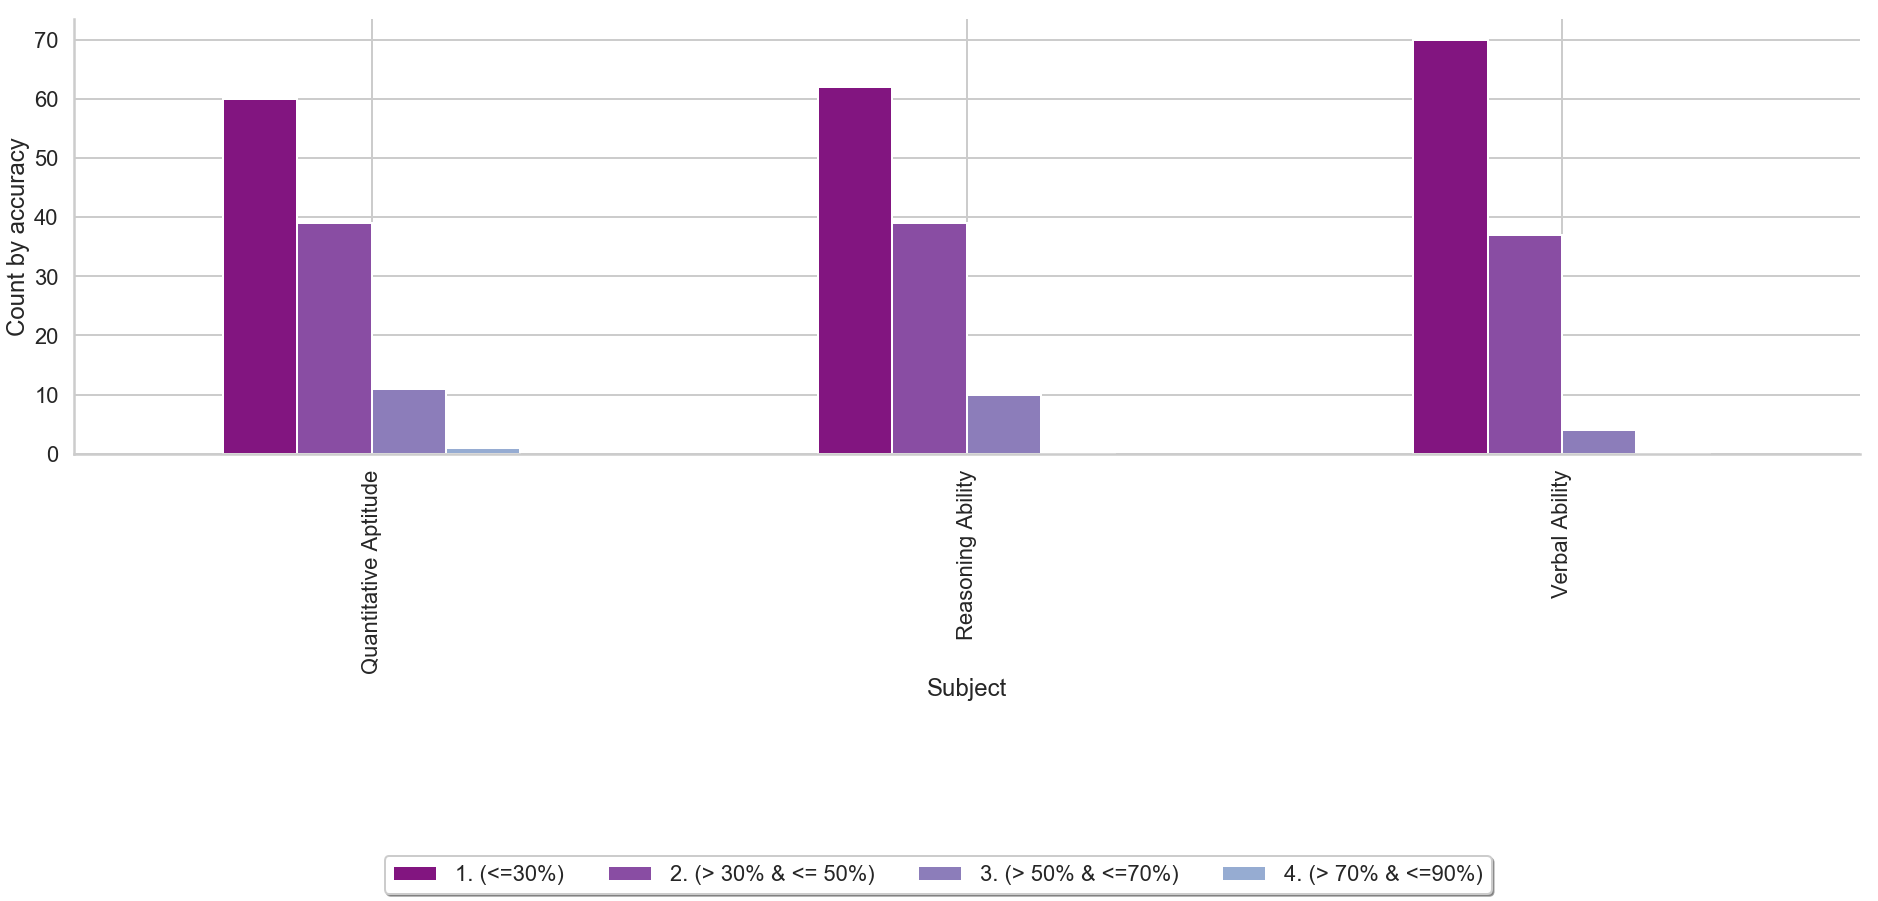

In [67]:
plt.rcParams['figure.figsize'] = [32, 8]
ax = slg.plot.bar()
ax.set_xlabel('Subject')
ax.set_ylabel('Count by accuracy')
sns.despine()
file = slugify(joiner.join(centerNames)) + "_studentPerfSummary_" + ''.join(random.choices(string.ascii_uppercase + string.digits, k=6)) + ".png"
#ax.get_figure().savefig(baseDir + file)
plt.legend(loc='upper right', bbox_to_anchor=(0.8, -0.9), shadow=True, ncol=5)

In [68]:
studentPerf.head()

,accuracy,speed,subject,user,PerformanceLevel
0,0.0,771.0,Quantitative Aptitude,Mohammad Feroz Ahmad Qureshi,1. (<=30%)
1,0.0,0.0,Quantitative Aptitude,Pankaj Chouhan,1. (<=30%)
2,0.0,95.0,Quantitative Aptitude,chenu vishnu vardhan,1. (<=30%)
3,0.0,9.0,Quantitative Aptitude,Kamlesh Kumar Sah,1. (<=30%)
4,10.0,350.0,Quantitative Aptitude,ampolu sai,1. (<=30%)


In [69]:
for subject in studentPerf['subject'].unique():
    col = 0
    filtered = studentPerf[studentPerf['subject'] == subject]
    for perfLevel in filtered['PerformanceLevel'].unique():
        filtered2 = filtered[filtered['PerformanceLevel'] == perfLevel]
        filtered3 = filtered2[['user', 'accuracy']]
        filtered3.columns = [perfLevel, '%']
        filtered3.to_excel(writer, sheet_name=subject[0:30], header=True, index=False, startcol=col)
        col = col + 3

In [70]:
#Find topics with lowest accuracy
topic_query = [
	{
	    '$match':{
	    	'isAbandoned': False,
            'practiceSetInfo.title': {'$in':testNames} 
	    }
	},
    { 
        "$sort" : {
            "createdAt" : 1.0
        }
    },
	{
	    '$group':{
	    	"_id": { "user":"$user", "test_id"  :"$practicesetId"},
	    	'subjects': {'$first': '$subjects'}
	    }
	},    
    {
        '$lookup':{
             'from': "users",
             'localField': "_id.user",
             'foreignField': "_id",
             'as': "attempt_users"            
        }
    },
	{
		'$project':{
			'user': '$attempt_users.name',
	        'subjects': 1
	    }
	},
	{
		'$unwind': '$subjects'
	},
	{
	    '$unwind': '$subjects.topics'
	},
	{
		'$project': {
	        'subject': '$subjects.name',
	        'topic': '$subjects.topics.name',
	      	'offscreenTime': {'$floor': {'$divide': [ '$subjects.offscreenTime', 60000]}},
	        'accr': {'$floor': {'$multiply': ['$subjects.accuracy', 100]}} ,
	       	'totalTime':{'$floor': {'$divide': [{'$multiply': ['$subjects.speed', {'$sum': ['$subjects.incorrect', '$subjects.missed', '$subjects.correct']}]}, 60000]}}
	    }
	},
	{
	    '$group':{
	    	'_id': {'user': '$user', 'subject':'$subject', 'topic':'$topic'},
	    	'time': {'$sum': '$totalTime'},
	    	'offscreen': {'$sum': '$offscreenTime'},
	    	'accuracy': {'$avg': '$accr'}
	    }
	},
	{
	    '$project':{
	        '_id': 0,
            'user': '$_id.user',
	    	'subject': '$_id.subject',
	    	'topic': '$_id.topic',
	    	'time': 1,
	    	'offscreen': 1,
	    	'accuracy': {'$floor': '$accuracy'}    
	    }
	},
	{
	    '$match':{
	    	'accuracy': {'$lt': 50}
	    }
	},
    {
        '$sort':{
            'accuracy': 1,
            'topic': 1,
            'subject': 1
        }
    }
]

In [71]:
topicPerf = pd.DataFrame(list(db.attempts.aggregate(topic_query)))
tp = topicPerf[['subject', 'topic', 'accuracy']]

In [72]:
tp.to_excel(writer, sheet_name='weakest_topics', index=False)

In [73]:
#save summary
filename = baseDir + slugify(joiner.join(centerNames)) + "_" + section + "_summary_" + ''.join(random.choices(string.ascii_uppercase + string.digits, k=6)) + ".json"
json.dump(summary, open(filename, 'w'))

In [74]:
writer.save()